## 1. Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, ConcatDataset
import torchvision
import torchvision.transforms.v2 as transforms
import numpy as np

from data import plot_raw_transfomed_examples, split_dataset, transform_to_tensor, transform_crop_and_resize, transform_res_net_18
from model import PneumoniaDetectionResNet18Model, PneumoniaDetectionMobileNetV3LargeModel
from trainer import Trainer
from datetime import datetime

In [2]:
# Global Parameters
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

allow_restnet18_training = False
resnet18_model_path = 'bin/2023_11_23_PneumoniaDetectionResNet18Model.pth'

allow_mobile_v3_large_training = True
mobile_v3_large_model_path = None

## 2. Dataset

Dataset: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia/data

In [3]:
train_set = torchvision.datasets.ImageFolder(root="data/train", transform=transforms.Compose([transform_to_tensor, transform_crop_and_resize]))
validation_set = torchvision.datasets.ImageFolder(root="data/val", transform=transforms.Compose([transform_to_tensor, transform_crop_and_resize]))
merged_dataset = ConcatDataset([train_set, validation_set])
train_set, validation_set = split_dataset(merged_dataset, 0.7)

test_set = torchvision.datasets.ImageFolder(root="data/test", transform=transforms.Compose([transform_to_tensor, transform_crop_and_resize]))

classes = test_set.classes
print(f"Classes: {test_set.class_to_idx}")

Classes: {'NORMAL': 0, 'PNEUMONIA': 1}


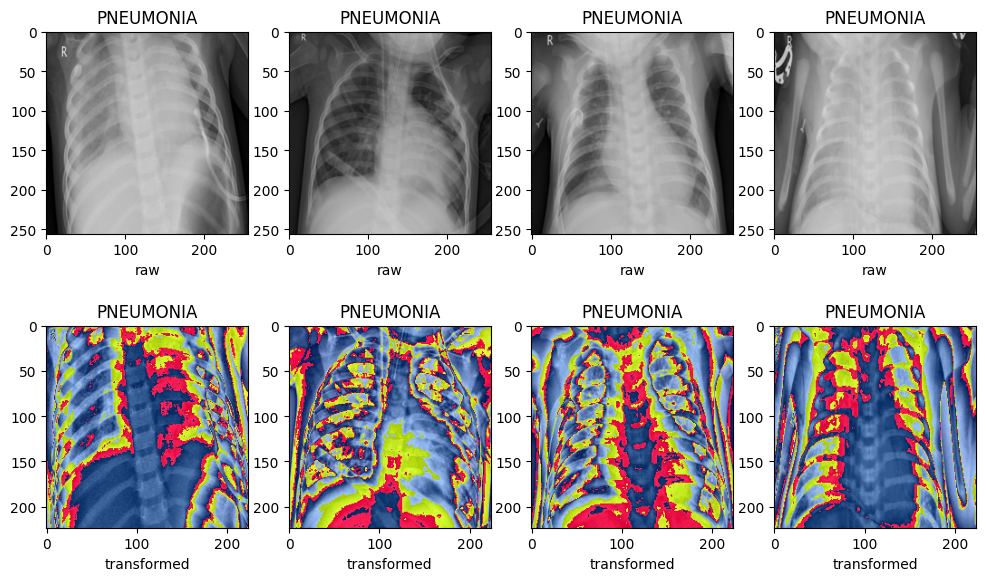

In [4]:
batch_size = 32
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, worker_init_fn=np.random.seed(333))
validation_loader = DataLoader(validation_set, batch_size=batch_size)
test_loader = DataLoader(test_set, batch_size=batch_size)

plot_raw_transfomed_examples(train_loader, classes, transform_res_net_18)

## 3. Model

### 3.1 ResNet-18

In [5]:
resnet18_model = PneumoniaDetectionResNet18Model()
print(resnet18_model)

PneumoniaDetectionResNet18Model(
  (transforms): ImageClassification(
      crop_size=[224]
      resize_size=[256]
      mean=[0.485, 0.456, 0.406]
      std=[0.229, 0.224, 0.225]
      interpolation=InterpolationMode.BILINEAR
  )
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_r

### 3.2 MobileNet v3

In [30]:
mobile_v3_large_model = PneumoniaDetectionMobileNetV3LargeModel()
print(mobile_v3_large_model)

PneumoniaDetectionMobileNetV3LargeModel(
  (transforms): ImageClassification(
      crop_size=[224]
      resize_size=[232]
      mean=[0.485, 0.456, 0.406]
      std=[0.229, 0.224, 0.225]
      interpolation=InterpolationMode.BILINEAR
  )
  (network): MobileNetV3(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=

## 4. Train

### 4.1 ResNet-18

In [25]:
adam_optimizer = optim.Adam(resnet18_model.parameters(), lr=0.00001)
loss_fn = nn.CrossEntropyLoss()
resnet18_trainer = Trainer(resnet18_model, train_loader, validation_loader, adam_optimizer, loss_fn=loss_fn, device=device, epochs=3)

In [26]:
if allow_restnet18_training:
    resnet18_trainer.fit()

    # save model and training history
    resnet18_model.set_history(resnet18_trainer.get_history())
    today = datetime.today().strftime("%Y_%m_%d")
    torch.save({ 
        "state_dict": resnet18_model.state_dict(),
        "history": resnet18_model.history
    }, 
    f"bin/{today}_{resnet18_model.__class__.__name__}.pth")
else:
    # load model and training history
    checkpoint = torch.load(resnet18_model_path)
    resnet18_model.load_state_dict(checkpoint['state_dict'])
    resnet18_model.set_history(checkpoint['history'])
    resnet18_trainer.set_history(resnet18_model.history)

### MobileNet v3

In [32]:
adam_optimizer = optim.Adam(mobile_v3_large_model.parameters(), lr=0.00001)
mobile_v3_large_trainer = Trainer(mobile_v3_large_model, train_loader, validation_loader, adam_optimizer, loss_fn=loss_fn, device=device, epochs=8)

In [33]:
if allow_mobile_v3_large_training:
    mobile_v3_large_trainer.fit()

    # save model and training history
    mobile_v3_large_model.set_history(mobile_v3_large_trainer.get_history())
    today = datetime.today().strftime("%Y_%m_%d")
    torch.save(mobile_v3_large_model.state_dict(), f"bin/{today}_{mobile_v3_large_model.__class__.__name__}.pth")
else:
    # load model and training history
    mobile_v3_large_model.load_state_dict(torch.load(mobile_v3_large_model_path))
    mobile_v3_large_trainer.set_history(mobile_v3_large_model.history)

Epoch [1/8], Step [0/115], Loss: 0.6740
Epoch [1/8], Step [10/115], Loss: 0.6556
Epoch [1/8], Step [20/115], Loss: 0.5829
Epoch [1/8], Step [30/115], Loss: 0.5141
Epoch [1/8], Step [40/115], Loss: 0.5197
Epoch [1/8], Step [50/115], Loss: 0.4900
Epoch [1/8], Step [60/115], Loss: 0.4536
Epoch [1/8], Step [70/115], Loss: 0.4073
Epoch [1/8], Step [80/115], Loss: 0.4276
Epoch [1/8], Step [90/115], Loss: 0.3476
Epoch [1/8], Step [100/115], Loss: 0.3303
Epoch [1/8], Step [110/115], Loss: 0.3798
Epoch [1/8], Validation Loss: 0.5333
Epoch [2/8], Step [0/115], Loss: 0.3610
Epoch [2/8], Step [10/115], Loss: 0.3143
Epoch [2/8], Step [20/115], Loss: 0.2723
Epoch [2/8], Step [30/115], Loss: 0.2481
Epoch [2/8], Step [40/115], Loss: 0.2812
Epoch [2/8], Step [50/115], Loss: 0.2224
Epoch [2/8], Step [60/115], Loss: 0.2576
Epoch [2/8], Step [70/115], Loss: 0.3033
Epoch [2/8], Step [80/115], Loss: 0.1476
Epoch [2/8], Step [90/115], Loss: 0.1710
Epoch [2/8], Step [100/115], Loss: 0.2385
Epoch [2/8], Step [

## 5. Evaluation

### 5.1 ResNet-18

Train accuracy: 0.992080807685852
Train f1 score: 0.992080807685852
Validation accuracy: 0.9891719818115234
Validation f1 score: 0.9891719818115234


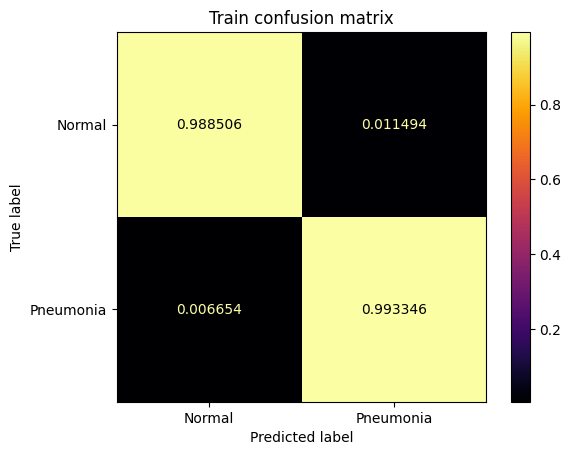

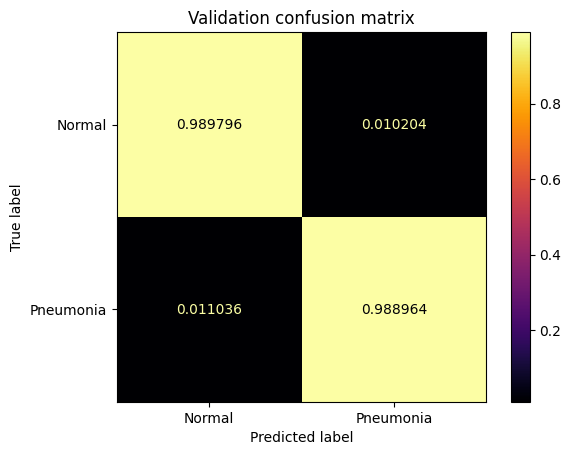

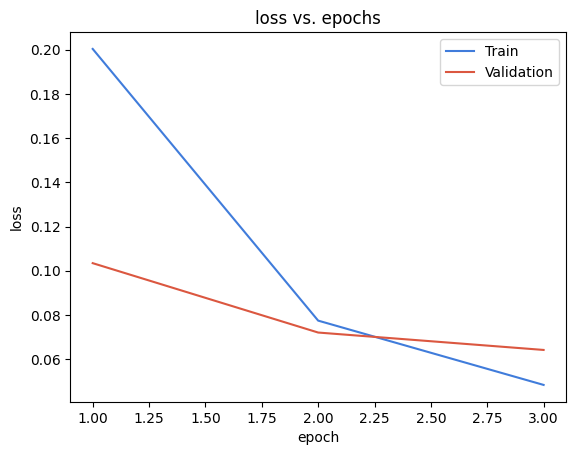

In [11]:
resnet18_trainer.evaluate()
resnet18_trainer.plot_loss()

### 5.2 MobileNet v3

Train accuracy: 0.9959038496017456
Train f1 score: 0.9959038496017456
Validation accuracy: 0.981528639793396
Validation f1 score: 0.981528639793396


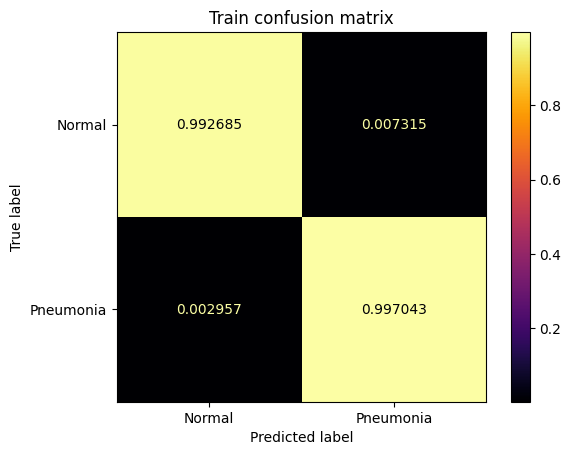

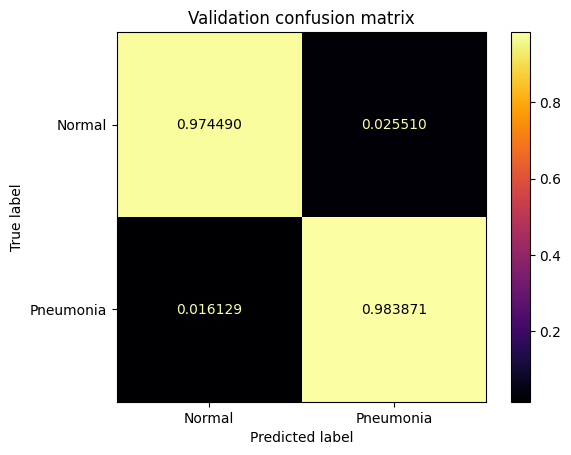

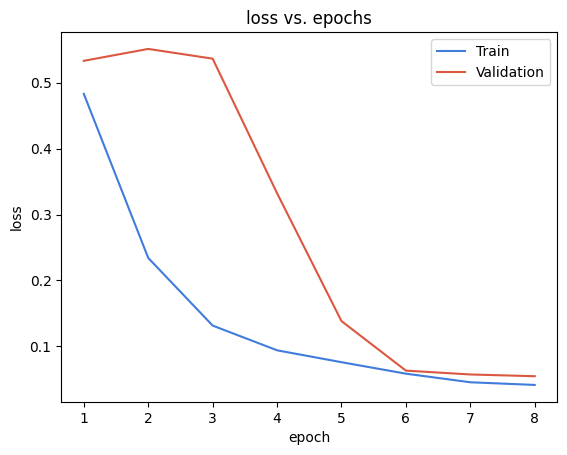

In [34]:
mobile_v3_large_trainer.evaluate()
mobile_v3_large_trainer.plot_loss()